Import packages

In [1]:
from collections import Counter
import math
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyradiobiology import LKB
from pyradiobiology.primitives import Dose, DoseType, DoseBag
import scipy as sp
from scipy import signal
from scipy import stats

Matplotlib is building the font cache; this may take a moment.


To install packages

In [ ]:
# import sys
# %conda install --yes --prefix {sys.prefix} scipy

# Apparently this package requires pip
# %pip install pyradiobiology

Set global variables

In [5]:
# PROJECT_DATA = os.path.join('jolien', 'Anonymized_planned_vs_delivered_dose_accumulation_data')
# INPUT_DIR = os.path.join('input_data', PROJECT_DATA)
INPUT_DIR = 'Anonymized_planned_vs_delivered_dose_accumulation_data'

ADAPTED_PATIENTS = [
    'a12d277b',
    'a6cecdc7',
    '0f21acd5',
    'c85c425b',
    '9b6b2bfa',
    '584a5f6f',
    '7a2278da',
    '65079eb2',
    '18a10b59',
    '80b18507',
    '5637a8a5',
    '4165ec7b',
    '3b0c9681',
    '6051d40d',
    'd87618b0',
    '152f067b',
    '2dfb48cd',
    '06bd9ded',
    '471c7d66',
    '9bf04b57',
    'a5495951',
    'b861a48f',
    'e19eaf8c',
    '8da2af5c',
    '113c1741'
]

## Define NTCP Models

In [6]:
def calculate_NTCP_LKB(doses, volumes, td50, m, n, ab_ratio, nfx):
    """
    Calculate the NTCP for a given patient using the Lyman-Kutcher-Burman (LKB) model.

    Parameters
    ----------
    doses : np.array[float]
        The dDVH doses in Gy.
    volumes : np.array[float]
        The dDVH volumes for each dose in cc.
    td50 : float
        The uniform dose to the whole organ resulting in 50% complication probability.
    m : float
        The slope of the NTCP curve.
    n : float
        The volume dependency parameter (n = 1 is the mean dose model).
    ab_ratio : float
        The a/B ratio of the tissue of interest.
    nfx : int
        The number of fractions for the treatment.
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCPs : np.array[float]
        The predicted NTCP using the LKB method.

    """
    # From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
    #   td50 = 39.9 Gy
    #   m = 0.4
    #   n = 1 (mean dose)
    # Other:
    #   a/B = 3
    lkb_model = LKB(td50=Dose.gy(td50, dose_type=DoseType.EQD2), m=m, n=n)
    NTCP = 100 * lkb_model.response_from_pysical_dose(
        dose_array_in_physical_dose = DoseBag.create(data=doses, dose_type=DoseType.PHYSICAL_DOSE),
        volume_array = volumes,
        ab_ratio = Dose.gy(ab_ratio),
        nfx = nfx
    )
    return NTCP

# def calculate_NTCP_Lee(mean_ipsalateral_parotid_dose, mean_contralateral_parotid_dose):
    # For the 3-month time point: S = −32.29 + (Dmean-c*0.637) + (Dmean-i*0.185) + (age*0.202)
    # For the 12-month time point: S = −44.87+ (Dmean-c*1.400) + (Dmean-i*0.358) + (T stage*corresponding coefficient);

def calculate_NTCP_Beetz(mean_contralateral_parotid_dose, baseline_xerostomia_score):
    """
    Calculate the NTCP for a given patient using the Beetz et al., 2012 paper.

    Parameters
    ----------
    mean_contralateral_parotid_dose : np.ndarray
        The mean dose to the contralateral parotid gland.
    baseline_xerostomia_score : np.ndarray
        The baseline xerostomia score (on a 4-point scale, I believe).
    verbose : bool, optional
        Whether to print the computed results (`True`) or not (`False`).

    Returns
    -------
    NTCP : float
        The predicted NTCP using the Beetz method.

    """
    S = -1.443 + (mean_contralateral_parotid_dose * 0.047) + (baseline_xerostomia_score * 0.720)
    NTCP = 100 * (1 + math.exp(-S))**(-1)
    return NTCP

## NTCP Plot Example

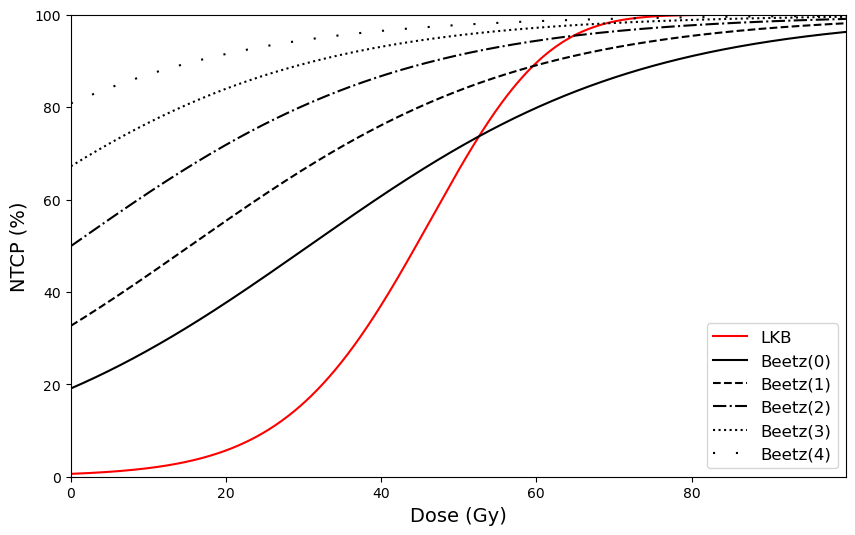

In [7]:
# Fake dose data
doses = np.arange(0,100,0.1)

all_linestyles = ['-','--','-.',':',(0,(1,10))]
plt.figure(figsize=(10,6))
# LKB
all_NTCPs_LKB = [calculate_NTCP_LKB([d], [1], 39.9, 0.4, 1, 3, 30) for d in doses]
plt.plot(doses, all_NTCPs_LKB, color='r', label='LKB')
# Beetz
for i,baseline_xerostomia_score in enumerate([0,1,2,3,4]):
    baseline_xerostomia_scores = baseline_xerostomia_score * np.ones(len(doses))
    all_NTCPs = [calculate_NTCP_Beetz(d,s) for d,s in zip(doses, baseline_xerostomia_scores)]
    plt.plot(doses, all_NTCPs, color='k', linestyle=all_linestyles[i], label=f'Beetz({baseline_xerostomia_score})')

plt.xlabel('Dose (Gy)', fontsize=14)
plt.ylabel('NTCP (%)', fontsize=14)
plt.xlim([0,max(doses)])
plt.ylim([0,100])
plt.legend(fontsize=12)
plt.show()

## Read in DVH output files

In [ ]:
def read_DVH_file_adaptive(file_name, output_dose_units='Gy'):
    """
    Read in the outputted adaptive DVH file.

    Parameters
    ----------
    file_name : str
        The name of the file to be read.
    output_dose_units : str, optional
        The desired units of the dose. The options are: `Gy` and
        `cGy`.

    Returns
    -------
    meta_info : dict
        This depends on the exact file given but for ours, the
        resulting attributes should be Patient ID, Plan Name,
        Resolution, Bin Width, Dose Units, and Volume Units. This
        will be of the format:
            {
                ATTRIBUTE_NAME1: ATTRIBUTE_VALUE1,
                ATTRIBUTE_NAME2: ATTRIBUTE_VALUE2,
                ...
            }
    dose_info : dict
        This will be of the format:
            {
                STRUCTURE1: [[DOSE_BINS], [dDVH], [cDVH]],
                STRUCTURE2: [[DOSE_BINS], [dDVH], [cDVH]],
                ...
            }

    """
    # Read the file
    with open(os.path.join(INPUT_DIR, file_name), 'r') as f:
        meta_lines = f.readlines()

    # First read the meta-data
    meta_info = {l.split(':')[0].strip() : l.split(':')[1].strip() for l in meta_lines[0].split('|')}
    # TODO: convert to usable time in Python (datetime)
    meta_info['Time'] = meta_lines[-1]

    # NOTE: not needed, should always be the same format ... I hope
    # column_names = [l.strip() for l in meta_lines[2].split('|')]
    raw_dose_info = [
        [
            l.split()[0],           # Structure / Organ
            float(l.split()[1]),    # Dose (value defined in `meta_info`)
            float(l.split()[2])     # Percent volume (%)
        ]
        for l in meta_lines[3:-3]   # Stop before the blank lines at the end
    ]

    # Determine the dose conversion factor
    dose_units = meta_info['Dose Units']
    if dose_units == output_dose_units:
        dose_conversion_factor = 1
    else:
        if (dose_units == 'cGy') and (output_dose_units == 'Gy'):
            dose_conversion_factor = 1/100
        elif (dose_units == 'Gy') and (output_dose_units == 'cGy'):
            dose_conversion_factor = 100
        else:
            raise Exception('Desired output dose units currently not supported')

    # Split into separate lists by structure
    all_structures = sorted(list(set([d[0] for d in raw_dose_info])))
    dose_info = {}
    for structure in all_structures:
        raw_dose_info_subset = [l for l in raw_dose_info if l[0] == structure]
        dose_info[structure] = np.array(
            [[dose_conversion_factor * d[1] for d in raw_dose_info_subset][:-1],    # Dose
            -np.diff([d[2] for d in raw_dose_info_subset]),                         # Differential DVH
            [d[2] for d in raw_dose_info_subset][:-1]]                              # Cumulative DVH
        )

    return meta_info, dose_info


# def read_DVH_file_Jolien(file_name, output_dose_units='Gy'):
#     """
#     Read in Jolien's DVH files.

#     Parameters
#     ----------
#     file_name : str
#         The name of the file to be read.
#     output_dose_units : str, optional
#         The desired units of the dose. The options are: `Gy` and
#         `cGy`.

#     Returns
#     -------
#     meta_info : dict
#         This depends on the exact file given but for ours, the
#         resulting attributes should be Patient ID, Plan Name,
#         Resolution, Bin Width, Dose Units, and Volume Units. This
#         will be of the format:
#             {
#                 ATTRIBUTE_NAME1: ATTRIBUTE_VALUE1,
#                 ATTRIBUTE_NAME2: ATTRIBUTE_VALUE2,
#                 ...
#             }
#     dose_info : dict
#         This will be of the format:
#             {
#                 STRUCTURE1: [[DOSE_BINS], [dDVH], [cDVH]],
#                 STRUCTURE2: [[DOSE_BINS], [dDVH], [cDVH]],
#                 ...
#             }

#     """
#     # Read the file
#     with open(os.path.join(INPUT_DIR, file_name), 'r') as f:
#         meta_lines = f.readlines()

#     # First read the meta-data
#     meta_info = {l.split(':')[0].strip() : l.split(':')[1].strip() for l in meta_lines[0].split('|')}
#     # TODO: convert to usable time in Python (datetime)
#     meta_info['Time'] = meta_lines[-1]

#     # NOTE: not needed, should always be the same format ... I hope
#     # column_names = [l.strip() for l in meta_lines[2].split('|')]
#     raw_dose_info = [
#         [
#             l.split()[0],           # Structure / Organ
#             float(l.split()[1]),    # Dose (value defined in `meta_info`)
#             float(l.split()[2])     # Percent volume (%)
#         ]
#         for l in meta_lines[3:-3]   # Stop before the blank lines at the end
#     ]

#     # Determine the dose conversion factor
#     dose_units = meta_info['Dose Units']
#     if dose_units == output_dose_units:
#         dose_conversion_factor = 1
#     else:
#         if (dose_units == 'cGy') and (output_dose_units == 'Gy'):
#             dose_conversion_factor = 1/100
#         elif (dose_units == 'Gy') and (output_dose_units == 'cGy'):
#             dose_conversion_factor = 100
#         else:
#             raise Exception('Desired output dose units currently not supported')

#     # Split into separate lists by structure
#     all_structures = sorted(list(set([d[0] for d in raw_dose_info])))
#     dose_info = {}
#     for structure in all_structures:
#         raw_dose_info_subset = [l for l in raw_dose_info if l[0] == structure]
#         dose_info[structure] = np.array(
#             [[dose_conversion_factor * d[1] for d in raw_dose_info_subset][:-1],    # Dose
#             -np.diff([d[2] for d in raw_dose_info_subset]),                         # Differential DVH
#             [d[2] for d in raw_dose_info_subset][:-1]]                              # Cumulative DVH
#         )

#     return meta_info, dose_info

## Accumulate DVHs

In [8]:
def convolve_DVHs(total_dose, fx_dose):
    conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
    cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
    plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
    new_total_dose = -np.diff(plot_conv_dose)
    return plot_conv_dose, new_total_dose

def compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx):
    new_total_dose = total_dose
    remaining_fx = final_fx - current_fx
    for _ in range(remaining_fx):
        plot_conv_dose, new_total_dose = convolve_DVHs(new_total_dose, fx_dose)
        # conv_dose = np.convolve(fx_dose, total_dose, mode='full')[0:len(fx_dose)]
        # cumsum_conv = np.cumsum(conv_dose[::-1])[::-1]
        # plot_conv_dose = (cumsum_conv - np.min(cumsum_conv)) / (np.max(cumsum_conv) - np.min(cumsum_conv))
        # total_dose = -np.diff(plot_conv_dose)
        # # plt.plot(x, plot_conv_dose, label=f'Predicted Dose fx: {current_fx+i+1}')
    return plot_conv_dose, new_total_dose

Test functions on dummy data

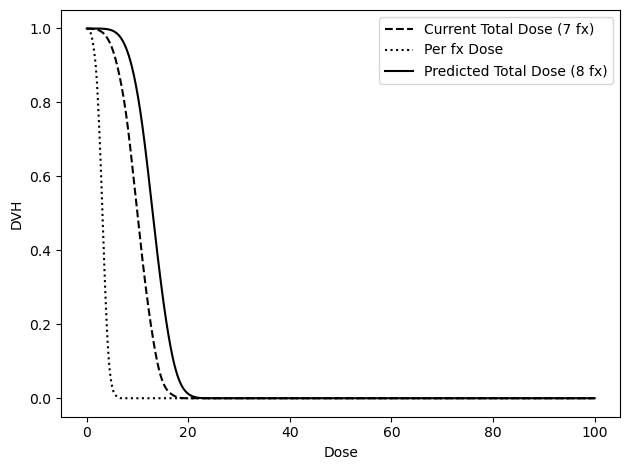

In [9]:
current_fx = 7
final_fx = 8
d1 = np.random.normal(3,1,1000)
x = np.linspace(0, 100, 1000)
total_dose = sp.stats.gaussian_kde(np.array(np.random.normal(10,3,1000)))(x)
fx_dose = sp.stats.gaussian_kde(np.array(d1))(x)

plt.figure()
cumsum_total_dose = np.cumsum(total_dose[::-1])[::-1]
cumsum_fx_dose = np.cumsum(fx_dose[::-1])[::-1]
plot_total_dose = (cumsum_total_dose-np.min(cumsum_total_dose))/(np.max(cumsum_total_dose)-np.min(cumsum_total_dose))
plot_fx_dose = (cumsum_fx_dose-np.min(cumsum_fx_dose))/(np.max(cumsum_fx_dose)-np.min(cumsum_fx_dose))
plt.plot(x, plot_total_dose, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, plot_fx_dose, color='k', linestyle=':', label='Per fx Dose')
predicted_total_dose,_ = compute_dose_at_fx(total_dose, fx_dose, current_fx, final_fx)
plt.plot(x, predicted_total_dose, color='k', label=f'Predicted Total Dose ({final_fx} fx)')


# plt.plot(x, nconv, color='k', label='Actual Accumulated Dose')
plt.xlabel('Dose')
plt.ylabel('DVH')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

Test code on a patient

NTCP = 0.67%


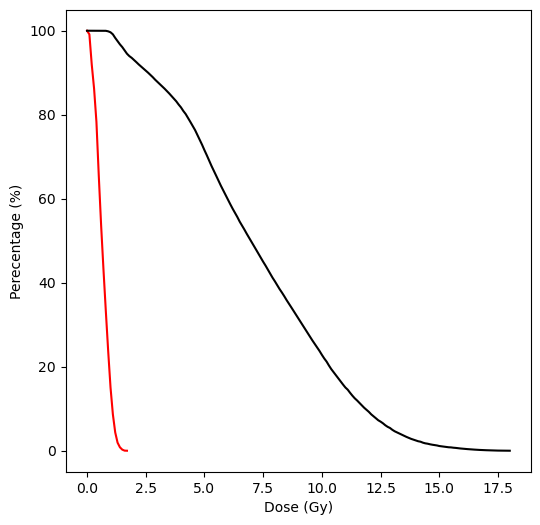

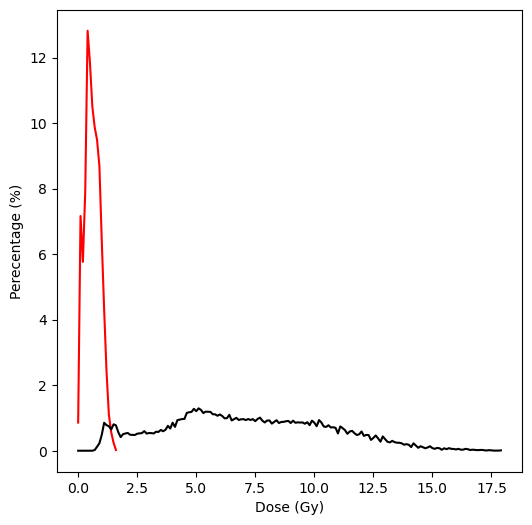

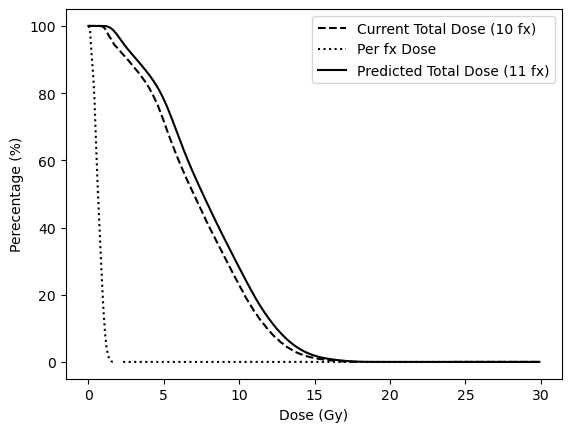

In [11]:
patient = '0c51fd88'
# dose_type = 'fx'
group_name = 'Original'
left_parotid_name = 'left parotid'
right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3

dDVHs = []
all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
assert len(all_accum_files) == len(all_fx_files)
nfx = len(all_fx_files)
all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[10]))
# Get only the desired structures
vol_ind = np.where(df_fx.columns == right_parotid_name)[0][0]+1
vol_col = df_fx.columns[vol_ind]
vol = float(vol_col)
dvh = df_fx[right_parotid_name]
dose_fx = np.array(dvh/100)
vol_percent_fx = np.array(df_fx.iloc[:,vol_ind])
# dDVH
dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
dDVH_percent_fx = -np.diff(vol_percent_fx)
dDVH_percent_fx = dDVH_percent_fx[~np.isnan(dDVH_percent_fx)]
# NTCP
NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_percent_fx, td50, m, n, aB_ratio, 1)
print(f'NTCP = {NTCP_fx:.2f}%')

# Predict the dose at the final fx
df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[10]))
# Get only the desired structures
vol_ind_accum = np.where(df_accum.columns == right_parotid_name)[0][0]+1
# vol_col_accum = df_accum.columns[vol_ind_accum]
# vol = float(vol_col_accum)
dvh_accum = df_accum[right_parotid_name]
dose_accum = np.array(dvh_accum/100)
vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
# dDVH
dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
dDVH_percent_accum = -np.diff(vol_percent_accum)
dDVH_percent_accum = dDVH_percent_accum[~np.isnan(dDVH_percent_accum)]

plt.figure(figsize=(6,6))
plt.plot(dose_fx, 100*vol_percent_fx, 'r')
plt.plot(dose_accum, 100*vol_percent_accum, 'k')
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(dDVH_dose_fx, 100*dDVH_percent_fx, 'r')
plt.plot(dDVH_dose_accum, 100*dDVH_percent_accum, 'k')
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

x = np.arange(0, 30, 0.1)
current_fx = 10
final_fx = 11
vol_percent_accum = np.pad(vol_percent_accum, (0,len(x)-len(vol_percent_accum)), 'constant')
vol_percent_fx = np.pad(vol_percent_fx, (0,len(x)-len(vol_percent_fx)), 'constant')
plt.plot(x, 100*vol_percent_accum, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, 100*vol_percent_fx, color='k', linestyle=':', label='Per fx Dose')
dDVH_percent_accum = np.pad(dDVH_percent_accum, (0,len(x)-len(dDVH_percent_accum)), 'constant')
dDVH_percent_fx_padded = np.pad(dDVH_percent_fx, (0,len(x)-len(dDVH_percent_fx)), 'constant')
vol_percent_predicted,_ = compute_dose_at_fx(dDVH_percent_accum, dDVH_percent_fx_padded, current_fx, final_fx)
plt.plot(x, 100*vol_percent_predicted, color='k', label=f'Predicted Total Dose ({final_fx} fx)')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

## Compute planned and delivered dose for all patients

In [ ]:
patient = '0c51fd88'
# dose_type = 'fx'
group_name = 'Original'
left_parotid_name = 'left parotid'
right_parotid_name = 'right parotid'
# From https://doi.org/10.1016%2Fj.ijrobp.2009.07.1708 (for parotid):
td50 = 39.9     # Gy
m = 0.4
n = 1           # Mean dose if n = 1
# Other:
aB_ratio = 3

dDVHs = []
all_fx_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' in f]
all_accum_files = [f for f in os.listdir(os.path.join(INPUT_DIR,patient,group_name)) if '.fx.' not in f]
assert len(all_accum_files) == len(all_fx_files)
nfx = len(all_fx_files)
all_fx_files = [f'RD.Accumulated.{i+1}.fx.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]
all_accum_files = [f'RD.Accumulated.{i+1}.dcm dvh {group_name.lower()}.csv' for i in range(nfx)]

# Is this 10 a specific fraction?
# df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[10]))
fx_no = 10
df_fx = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_fx_files[fx_no]))
# Get only the desired structures
vol_ind = np.where(df_fx.columns == right_parotid_name)[0][0]+1
vol_col = df_fx.columns[vol_ind]
vol = float(vol_col)
dvh = df_fx[right_parotid_name]
dose_fx = np.array(dvh/100)
vol_percent_fx = np.array(df_fx.iloc[:,vol_ind])
# dDVH
dDVH_dose_fx = dose_fx[~np.isnan(dose_fx)][:-1]
dDVH_percent_fx = -np.diff(vol_percent_fx)
dDVH_percent_fx = dDVH_percent_fx[~np.isnan(dDVH_percent_fx)]
# NTCP
NTCP_fx = calculate_NTCP_LKB(dDVH_dose_fx, dDVH_percent_fx, td50, m, n, aB_ratio, 1)
print(f'NTCP = {NTCP_fx:.2f}%')

# Predict the dose at the final fx
df_accum = pd.read_csv(os.path.join(INPUT_DIR,patient,group_name,all_accum_files[10]))
# Get only the desired structures
vol_ind_accum = np.where(df_accum.columns == right_parotid_name)[0][0]+1
# vol_col_accum = df_accum.columns[vol_ind_accum]
# vol = float(vol_col_accum)
dvh_accum = df_accum[right_parotid_name]
dose_accum = np.array(dvh_accum/100)
vol_percent_accum = np.array(df_accum.iloc[:,vol_ind_accum])
# dDVH
dDVH_dose_accum = dose_accum[~np.isnan(dose_accum)][:-1]
dDVH_percent_accum = -np.diff(vol_percent_accum)
dDVH_percent_accum = dDVH_percent_accum[~np.isnan(dDVH_percent_accum)]

plt.figure(figsize=(6,6))
plt.plot(dose_fx, 100*vol_percent_fx, 'r')
plt.plot(dose_accum, 100*vol_percent_accum, 'k')
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(dDVH_dose_fx, 100*dDVH_percent_fx, 'r')
plt.plot(dDVH_dose_accum, 100*dDVH_percent_accum, 'k')
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

x = np.arange(0, 30, 0.1)
current_fx = 10
final_fx = 11
vol_percent_accum = np.pad(vol_percent_accum, (0,len(x)-len(vol_percent_accum)), 'constant')
vol_percent_fx = np.pad(vol_percent_fx, (0,len(x)-len(vol_percent_fx)), 'constant')
plt.plot(x, 100*vol_percent_accum, color='k', linestyle='--', label=f'Current Total Dose ({current_fx} fx)')
plt.plot(x, 100*vol_percent_fx, color='k', linestyle=':', label='Per fx Dose')
dDVH_percent_accum = np.pad(dDVH_percent_accum, (0,len(x)-len(dDVH_percent_accum)), 'constant')
dDVH_percent_fx_padded = np.pad(dDVH_percent_fx, (0,len(x)-len(dDVH_percent_fx)), 'constant')
vol_percent_predicted,_ = compute_dose_at_fx(dDVH_percent_accum, dDVH_percent_fx_padded, current_fx, final_fx)
plt.plot(x, 100*vol_percent_predicted, color='k', label=f'Predicted Total Dose ({final_fx} fx)')
plt.legend()
plt.xlabel('Dose (Gy)')
plt.ylabel('Perecentage (%)')
plt.show()

## Read in DVHs

In [ ]:
cleaned_input_dir = os.path.join('input_data','jolien','anonymized_cleaned_dose')
all_patients = os.listdir(cleaned_input_dir)

all_df_fx = {}
for patient in all_patients:
    all_df_fx[patient] = []
    all_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' in f]
    nfx = len(all_fx_files)
    for fx in range(nfx):
        all_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_fx_files[fx])).dropna())

all_df_accum = {}
for patient in all_patients:
    all_df_accum[patient] = []
    all_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' not in f]
    nfx = len(all_accum_files)
    for fx in range(nfx):
        all_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_accum_files[fx])).dropna())

all_adapted_df_fx = {}
for patient in ADAPTED_PATIENTS:
    all_adapted_df_fx[patient] = []
    all_adapted_fx_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' in f]
    nfx = len(all_adapted_fx_files)
    for fx in range(nfx):
        all_adapted_df_fx[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_fx_files[fx])).dropna())

all_adapted_df_accum = {}
for patient in ADAPTED_PATIENTS:
    all_adapted_df_accum[patient] = []
    all_adapted_accum_files = [f for f in os.listdir(os.path.join(cleaned_input_dir,patient)) if '.fx.' not in f]
    nfx = len(all_adapted_accum_files)
    for fx in range(nfx):
        all_adapted_df_accum[patient].append(pd.read_csv(os.path.join(cleaned_input_dir, patient, all_adapted_accum_files[fx])).dropna())